<a href="https://colab.research.google.com/github/ReemAbdelhaleemHassan/Face-Recognition/blob/main/NonFace_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code to read file into Colaboratory:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **Upload non-faces dataset**

In [ ]:
link = 'https://drive.google.com/file/d/1csdpO4I9u7FGUD7CNxwEkQpIAqhiD5c_/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('non-face.zip')

## **Upload faces dataset**

In [ ]:
# upload CSV file from google drive
link = 'https://drive.google.com/file/d/1Mb0WeDv0s1Y3K7f1-3Qp7iFUfFw6K_GF/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('archive.zip')

## **Zipping the datasets**

In [ ]:
! unzip non-face.zip -d non-faces
! unzip archive.zip -d faces

## **Imports**

In [ ]:
import numpy as np
import cv2 as cv
import os
#from google.colab.patches import cv2_imshow # for image display
#from skimage import io
#from PIL import Image 
import matplotlib.pylab as plt
import matplotlib.pyplot as plt1
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tabulate import tabulate
from prettytable import PrettyTable
from PIL import Image as im
from sklearn.model_selection import train_test_split

## **Convert image to vector function**

In [ ]:
def vectorizing(imagename):
  img=cv.imread(imagename)
  result = img[:, :, 0]
  img_np = np.asarray(result)
  img_np= img_np.flatten()
  return img_np

## **Apply vectorizing on the datasets**

In [ ]:
directory = os.fsencode("/content/faces/")
faces_dataset = []
for file in sorted(os.listdir(directory)):
      filename = os.fsdecode(file)
      filename= "/content/faces/"+ filename +"/"
      filenameV= os.fsencode(filename)
      for image in os.listdir(filenameV):
        imagename = os.fsdecode(image)
        imagename= filename+imagename
        faces_dataset.append(vectorizing(imagename))

In [ ]:
directory = os.fsencode("/content/non-faces/")
non_faces_dataset = []
for file in os.listdir(directory):
      filename = os.fsdecode(file)
      filename= "/content/non-faces/"+ filename +"/"
      filenameV= os.fsencode(filename)
      for image in os.listdir(filenameV):
        imagename = os.fsdecode(image)
        imagename= filename+imagename
        non_faces_dataset.append(vectorizing(imagename))

## **Generate labels vector**

In [ ]:
# 0--> non-face and 1-->face
labels = []
for i in range(850):
  if i < 400:
    labels.append(1)
  else:
    labels.append(0)

## **Convert datasets to NumPy (n,d)**

In [ ]:
non_faces_dataset = np.array(non_faces_dataset)
faces_dataset = np.array(faces_dataset)
labels = np.array([labels]).transpose()
print(non_faces_dataset.shape)
print(faces_dataset.shape)
print(labels.shape)

(450, 10304)
(400, 10304)
(850, 1)


## **Concatenate into one dataset**

In [ ]:
dataset = np.concatenate((faces_dataset,non_faces_dataset))
print(dataset.shape)

(850, 10304)


## **Splitting Function**

In [ ]:
def split(dataset,labels,ratio=0.3):
  train_features, test_features, train_labels, test_labels = train_test_split(dataset, labels, test_size=ratio, random_state=42,stratify=labels)
  return train_features, test_features, train_labels, test_labels

## **PCA**

In [ ]:
def pca(dataset,alpha):
  mean=dataset.mean(axis=0)
  Z=dataset-mean
  cov=np.cov(Z,rowvar=False,bias=False)
  eigen_values,eigen_vectors=np.linalg.eigh(cov)
  r=0
  sum=0.0
  n=len(eigen_values)
  eigen_values_sum=math.fsum(eigen_values)
  for i in reversed(range(n)):
    sum=sum+eigen_values[i]
    tolerance=float(sum/eigen_values_sum)
    if tolerance>=alpha:
      r=i
      break
  P=eigen_vectors[:,r:n]
  return P

## **Projection function**

In [ ]:
def projection(features,P):
  features=features-features.mean(axis=0)
  projected_features=np.dot(features,P)
  return projected_features

## **KNN Classifier**

In [ ]:
def knn(train_features,train_labels,k):
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(train_features,train_labels.ravel())
  return clf

In [ ]:
def get_accuracy(clf,test_features,test_labels):
  predicition  = clf.predict(test_features)
  acc = accuracy_score(predicition,test_labels)
  return acc

## **Apply PCA on full Dataset with Alpha=0.95 and k=1**



In [ ]:
train_features, test_features, train_labels, test_labels = split(dataset,labels)
projection_matrix = pca(train_features,0.95)

In [ ]:
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

## **With 400 faces and 450 non-faces samples**

In [ ]:
clf = knn(projected_train_features,train_labels,1)
acc = get_accuracy(clf,projected_test_features,test_labels)
r = projected_train_features.shape[1]
print(acc)
print(r)

0.9254901960784314
200


## **To record the accuracies and R satisfying alpha=0.95**

In [ ]:
acc_list = []
r_list = []

## **With 400 faces and 100 non-faces samples**

In [ ]:
# slice non-faces dataset
d1 = np.concatenate((faces_dataset,non_faces_dataset[0:100]))
l1 = labels[0:500]
# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d1,l1)

# get the projection matrix computed using PCA
projection_matrix = pca(train_features,0.95)

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))
r_list.append(projected_train_features.shape[1])

print(acc_list[-1]) 
print(r_list[-1]) 

0.9533333333333334
153


## **With 400 faces and 150 non-faces samples**

In [ ]:
# slice non-faces dataset
d2 = np.concatenate((faces_dataset,non_faces_dataset[0:150]))
l2 = labels[0:550]
# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d2,l2)

# get the projection matrix computed using PCA
projection_matrix = pca(train_features,0.95)

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))
r_list.append(projected_train_features.shape[1])

print(acc_list[-1]) 
print(r_list[-1]) 

0.9272727272727272
149


## **With 400 faces and 200 non-faces samples**



In [ ]:
# slice non-faces dataset
d3 = np.concatenate((faces_dataset,non_faces_dataset[0:200]))
l3 = labels[0:600]
# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d3,l3)

# get the projection matrix computed using PCA
projection_matrix = pca(train_features,0.95)

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))
r_list.append(projected_train_features.shape[1])

print(acc_list[-1]) 
print(r_list[-1])

0.9388888888888889
162


## **With 400 faces and 250 non-faces samples**



In [ ]:
# slice non-faces dataset
d4 = np.concatenate((faces_dataset,non_faces_dataset[0:250]))
l4 = labels[0:650]
# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d4,l4)

# get the projection matrix computed using PCA
projection_matrix = pca(train_features,0.95)

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))
r_list.append(projected_train_features.shape[1])

print(acc_list[-1]) 
print(r_list[-1])

0.958974358974359
168


## **With 400 faces and 300 non-faces samples**



In [ ]:
# slice non-faces dataset
d5 = np.concatenate((faces_dataset,non_faces_dataset[0:300]))
l5 = labels[0:700]
# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d5,l5)

# get the projection matrix computed using PCA
projection_matrix = pca(train_features,0.95)

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))
r_list.append(projected_train_features.shape[1])

print(acc_list[-1]) 
print(r_list[-1])

0.9142857142857143
177


## **With 400 faces and 350 non-faces samples**



In [ ]:
# slice non-faces dataset
d6 = np.concatenate((faces_dataset,non_faces_dataset[0:350]))
l6 = labels[0:750]
# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d6,l6)

# get the projection matrix computed using PCA
projection_matrix = pca(train_features,0.95)

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))
r_list.append(projected_train_features.shape[1])

print(acc_list[-1]) 
print(r_list[-1])

0.9422222222222222
181


## **With 400 faces and 400 non-faces samples**



In [ ]:
# slice non-faces dataset
d7 = np.concatenate((faces_dataset,non_faces_dataset[0:400]))
l7 = labels[0:800]
# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d7,l7)

# get the projection matrix computed using PCA
projection_matrix = pca(train_features,0.95)

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))
r_list.append(projected_train_features.shape[1])

print(acc_list[-1]) 
print(r_list[-1])

0.9333333333333333
190


## **With 400 faces and 450 non-faces samples**



In [ ]:
# slice non-faces dataset
d8 = np.concatenate((faces_dataset,non_faces_dataset[0:450]))
l8 = labels[0:850]
# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d8,l8)

# get the projection matrix computed using PCA
projection_matrix = pca(train_features,0.95)

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))
r_list.append(projected_train_features.shape[1])

print(acc_list[-1]) 
print(r_list[-1])

0.9254901960784314
200


## **Plot Accuracy vs number of non-faces samples in the dataset**

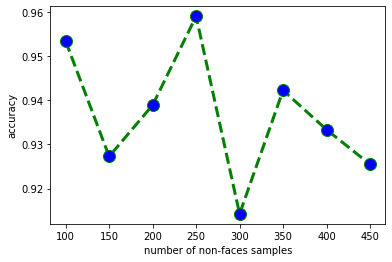

In [ ]:
ranges = [100,150,200,250,300,350,400,450]
plt.plot(ranges, acc_list,color='green', linestyle='dashed', linewidth = 3,marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('number of non-faces samples')
plt.ylabel('accuracy')
plt.show()

## **Plot R vs number of non-faces samples in the dataset**

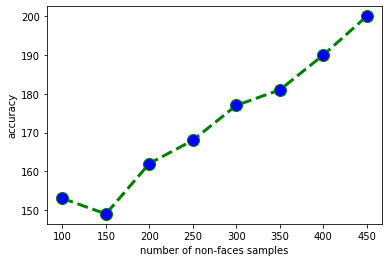

In [ ]:
plt.plot(ranges, r_list,color='green', linestyle='dashed', linewidth = 3,marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('number of non-faces samples')
plt.ylabel('R')
plt.show()

In [ ]:
def get_length(labels):
  sum_0 = 0
  sum_1 = 0
  for i in labels:
    if i==0:
      sum_0+=1
    else:
      sum_1 +=1
  return sum_0,sum_1

## **LDA**

In [ ]:
def lda_2(train_features,labels):
  n1,n2 = get_length(labels)
  Stotal=np.zeros(shape=(train_features.shape[1],train_features.shape[1]))
  mean_1 = np.mean(train_features[0:n1],axis=0)          # (10304,0)
  mean_2 = np.mean(train_features[n1:n1+n2],axis=0)        # (10304,0)
  Z1 = train_features[0:n1] - mean_1
  Z2 = train_features[n1:n1+n2] - mean_2
  m = mean_1 - mean_2
  m = np.reshape(m, (train_features.shape[1], 1))
  B = np.dot(m,m.transpose())                             #
  S1 = np.dot(Z1.transpose(),Z1)
  S2 = np.dot(Z2.transpose(),Z2)
  Stotal = S1 + S2
  eigen_val,eigen_vec = np.linalg.eigh(np.linalg.inv(Stotal).dot(B))
  return eigen_vec[:,-1]

## **Apply LDA on dataset with 400 faces and 100 non-faces samples**

In [ ]:
# slice non-faces dataset
d1 = np.concatenate((faces_dataset,non_faces_dataset[0:100]))
l1 = labels[0:500]

# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d1,l1)

# get the projection matrix computed using LDA
projection_matrix = lda_2(train_features,train_labels)

# reshaping the projection matrix
projection_matrix=np.reshape(projection_matrix, (10304, 1))

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))
r_list.append(projected_train_features.shape[1])

print(acc_list[-1]) 
print(r_list[-1])

0.82
1


## **Apply LDA on dataset with 400 faces and 150 non-faces samples**

In [ ]:
# slice non-faces dataset
d2 = np.concatenate((faces_dataset,non_faces_dataset[0:150]))
l2 = labels[0:550]

# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d2,l2)

# get the projection matrix computed using LDA
projection_matrix = lda_2(train_features,train_labels)

# reshaping the projection matrix
projection_matrix=np.reshape(projection_matrix, (10304, 1))

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))
r_list.append(projected_train_features.shape[1])

print(acc_list[-1]) 
print(r_list[-1])

0.8363636363636363
1


## **Apply LDA on dataset with 400 faces and 200 non-faces samples**

In [ ]:
# slice non-faces dataset
d3 = np.concatenate((faces_dataset,non_faces_dataset[0:200]))
l3 = labels[0:600]

# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d3,l3)

# get the projection matrix computed using LDA
projection_matrix = lda_2(train_features,train_labels)

# reshaping the projection matrix
projection_matrix=np.reshape(projection_matrix, (10304, 1))

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))

print(acc_list[-1]) 

## **Apply LDA on dataset with 400 faces and 250 non-faces samples**

In [ ]:
# slice non-faces dataset
d4 = np.concatenate((faces_dataset,non_faces_dataset[0:250]))
l4 = labels[0:650]

# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d4,l4)

# get the projection matrix computed using LDA
projection_matrix = lda_2(train_features,train_labels)

# reshaping the projection matrix
projection_matrix=np.reshape(projection_matrix, (10304, 1))

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))

print(acc_list[-1]) 

## **Apply LDA on dataset with 400 faces and 300 non-faces samples**

In [ ]:
# slice non-faces dataset
d5 = np.concatenate((faces_dataset,non_faces_dataset[0:300]))
l5 = labels[0:700]

# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d5,l5)

# get the projection matrix computed using LDA
projection_matrix = lda_2(train_features,train_labels)

# reshaping the projection matrix
projection_matrix=np.reshape(projection_matrix, (10304, 1))

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))

print(acc_list[-1]) 

## **Apply LDA on dataset with 400 faces and 350 non-faces samples**

In [ ]:
# slice non-faces dataset
d6 = np.concatenate((faces_dataset,non_faces_dataset[0:350]))
l6 = labels[0:750]

# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d6,l6)

# get the projection matrix computed using LDA
projection_matrix = lda_2(train_features,train_labels)

# reshaping the projection matrix
projection_matrix=np.reshape(projection_matrix, (10304, 1))

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))

print(acc_list[-1]) 

## **Apply LDA on dataset with 400 faces and 400 non-faces samples**

In [ ]:
# slice non-faces dataset
d7 = np.concatenate((faces_dataset,non_faces_dataset[0:400]))
l7 = labels[0:800]

# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d7,l7)

# get the projection matrix computed using LDA
projection_matrix = lda_2(train_features,train_labels)

# reshaping the projection matrix
projection_matrix=np.reshape(projection_matrix, (10304, 1))

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))

print(acc_list[-1]) 

## **Apply LDA on dataset with 400 faces and 450 non-faces samples**

In [ ]:
# slice non-faces dataset
d8 = np.concatenate((faces_dataset,non_faces_dataset[0:450]))
l8 = labels[0:850]

# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d8,l8)

# get the projection matrix computed using LDA
projection_matrix = lda_2(train_features,train_labels)

# reshaping the projection matrix
projection_matrix=np.reshape(projection_matrix, (10304, 1))

# project the train and test sets on the projection matrix
projected_train_features = projection(train_features,projection_matrix)
projected_test_features = projection(test_features,projection_matrix)

# use knn classifier
clf = knn(projected_train_features,train_labels,1)

# store the results
acc_list.append(get_accuracy(clf,projected_test_features,test_labels))

print(acc_list[-1]) 

## **Plot Accuracy vs number of non-faces samples**

In [ ]:
ranges = [100,150,200,250,300,350,400,450]
plt.plot(ranges, acc_list[8,16],color='green', linestyle='dashed', linewidth = 3,marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('number of non-faces samples')
plt.ylabel('accuracy')
plt.show()

## **Apply PCA and LDA on 400 faces and 400 non-faces samples**

In [ ]:
# slice non-faces dataset
d = np.concatenate((faces_dataset,non_faces_dataset[0:400]))
l = labels[0:800]

# split into train and test sets 
train_features, test_features, train_labels, test_labels = split(d,l)

# apply PCA with alpha=0.95
projection_matrix_pca = pca(train_features,0.95)

# project the train and test sets on the projection matrix
projected_train_features_pca = projection(train_features,projection_matrix_pca)
projected_test_features_pca = projection(test_features,projection_matrix_pca)

# get the projection matrix computed using LDA 
projection_matrix_lda = lda_2(projected_train_features_pca,train_labels)

#reshaping the projection matrix
projection_matrix_lda=np.reshape(projection_matrix_lda, (projected_train_features_pca.shape[1], 1))

# project the train and test sets on the projection matrix
projected_train_features_lda = projection(projected_train_features_pca,projection_matrix_lda)
projected_test_features_lda = projection(projected_test_features_pca,projection_matrix_lda)

# use knn classifier
clf = knn(projected_train_features_lda,train_labels,1)

# store the results
accuracy = get_accuracy(clf,projected_test_features_lda,test_labels)
print(accuracy)

## **Show failure and success cases**

In [ ]:
def test_image(image_vector,clf):
  pred = clf.predict([image_vector])
  image_vector = np.reshape(image_vector, (112, 92))
  img = im.fromarray(image_vector)
  return img, pred

In [ ]:
# you may find corrupted images due to resize
classifier = knn(train_features,train_labels,1)
test = non_faces_dataset[400:450]
for x in test:
  image, pred = test_image(x,classifier)
  display(image)
  if pred == [0]:
    print("Non-Face")
  else:
    print("Face")
  print("----------------------------------------------------")